In [ ]:
# git:  https://github.com/ricejfx/aihc

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import dask.dataframe as dd

import networkx as nx
from matplotlib.colors import LogNorm

In [29]:
plt.rcParams["font.family"] = "Arial"

# Convert Chart Events to Parquet

In [46]:
chunksize = 5e6
src_file = "./mimicIII/mimic-iii-clinical-database-1.4/CHARTEVENTS.csv.gz"

reader = pd.read_csv(src_file, chunksize=chunksize, compression='gzip')  

total_rows = 0
for i, chunk in enumerate(tqdm.tqdm(reader, total=(330e6)//chunksize, desc="Counting Rows")):
    total_rows += len(chunk)

print(f"Final: {total_rows=}")


Counting Rows:   9%|▉         | 6/66.0 [00:23<03:52,  3.87s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Counting Rows:  58%|█████▊    | 38/66.0 [02:37<01:57,  4.21s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Counting Rows:  77%|███████▋  | 51/66.0 [03:31<01:02,  4.14s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Counting Rows:  79%|███████▉  | 52/66.0 [03:35<00:56,  4.06s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterab

Final: total_rows=330712483


TypeError: 'module' object is not callable. Did you mean: 'tqdm.tqdm(...)'?

In [49]:
chunksize = 10e6

reader = pd.read_csv(src_file, chunksize=chunksize, compression='gzip')  

for i, chunk in enumerate(tqdm.tqdm(reader, total=total_rows//chunksize, desc="Processing Chunks")):
    # Convert VALUE column to numeric, setting errors to NaN
    chunk["VALUE"] = pd.to_numeric(chunk["VALUE"], errors="coerce")

    # Save each chunk as a separate Parquet file
    chunk.to_parquet(f"CHARTEVENTS_{i}.parquet", engine="pyarrow", index=False)


Processing Chunks:   9%|▉         | 3/33.0 [00:36<06:09, 12.31s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing Chunks:  58%|█████▊    | 19/33.0 [05:18<04:09, 17.83s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing Chunks:  76%|███████▌  | 25/33.0 [07:03<02:20, 17.57s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
Processing Chunks:  79%|███████▉  | 26/33.0 [07:19<01:59, 17.11s/it]c:\Users\ricej\anaconda3\Lib\site-packages\tqdm\std.py:1181: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  f

# Load some Dataframes

In [302]:
transfers_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/TRANSFERS.csv.gz")

In [305]:
for col in ["INTIME", "OUTTIME"]:
    transfers_df[col] = pd.to_datetime(transfers_df[col])

In [141]:
diagnoses_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv.gz")

In [144]:
diagnoses_df["SEQ_NUM"].describe()

count    651000.000000
mean          7.913836
std           6.072633
min           1.000000
25%           3.000000
50%           6.000000
75%          11.000000
max          39.000000
Name: SEQ_NUM, dtype: float64

In [60]:
icu_stays_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz")
for col in ["INTIME", "OUTTIME"]:
    icu_stays_df[col] = pd.to_datetime(icu_stays_df[col])



In [79]:
icu_stays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
365,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
366,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
367,3,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
368,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
369,5,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729


In [78]:
icu_stays_df.sort_values(by=["SUBJECT_ID", "INTIME"], inplace=True)

In [59]:
subject_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/PATIENTS.csv.gz")

for col in ["DOB", "DOD", "DOD_HOSP"]:
    subject_df[col] = pd.to_datetime(subject_df[col])

In [2]:
chart_events_df = dd.read_parquet("./parquet/CHARTEVENTS_*.parquet", engine="pyarrow")

In [5]:
rx_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv.gz")

C:\Users\ricej\AppData\Local\Temp\ipykernel_36456\1977445061.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  rx_df = pd.read_csv("./mimicIII/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv.gz")


In [6]:
rx_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


In [7]:
rx_df["STARTDATE_DT"] = pd.to_datetime(rx_df["STARTDATE"])
rx_df["ENDDATE_DT"] = pd.to_datetime(rx_df["ENDDATE"])

In [9]:
rx_df[["STARTDATE_DT","ENDDATE_DT"]].diff(axis=1)["ENDDATE_DT"].value_counts()#.dt.days.value_counts().sort_index().plot(kind="bar")

ENDDATE_DT
1 days        1557704
0 days         856103
2 days         470431
3 days         319407
4 days         212737
               ...   
160 days            1
138 days            1
144 days            1
139 days            1
-3654 days          1
Name: count, Length: 227, dtype: int64

# Number of ICU Vists by Patient

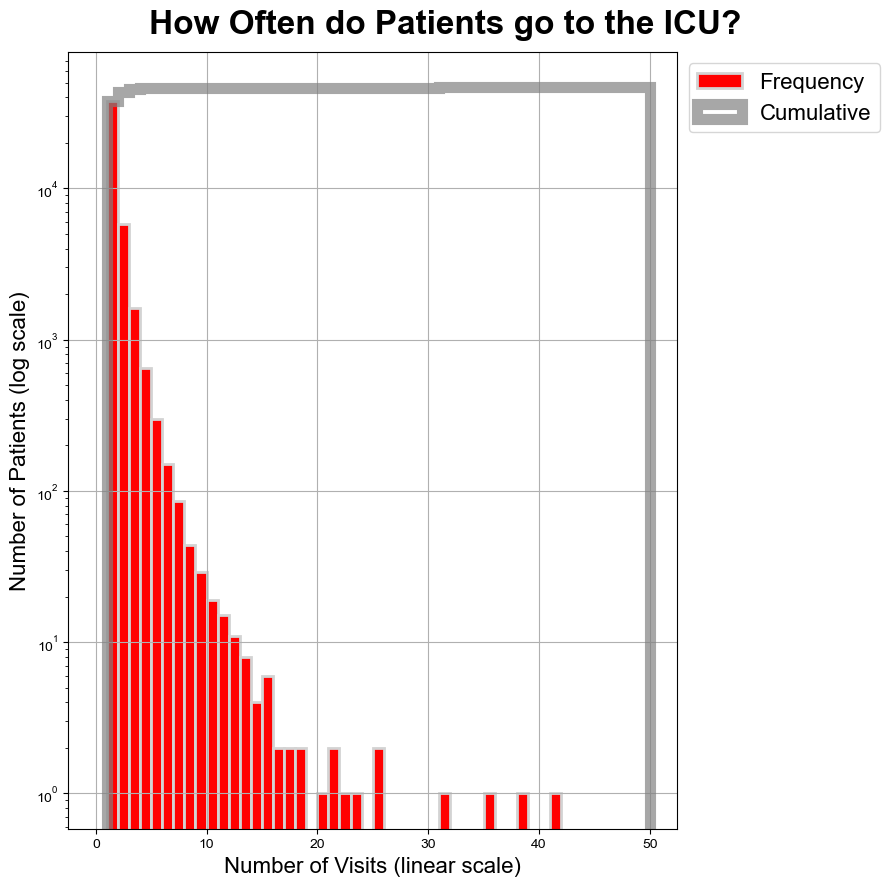

In [392]:
fig, ax = plt.subplots(figsize=(9,9))
bins = np.arange(0,51,1)
ax.hist(icu_stays_df.groupby(["SUBJECT_ID"])["ROW_ID"].count().values, bins=bins, color="red", linewidth=2,
        edgecolor="lightgray", label="Frequency")
ax.hist(icu_stays_df.groupby(["SUBJECT_ID"])["ROW_ID"].count().values, bins=bins, color="red", linewidth=8,
        edgecolor="gray", cumulative=1, histtype="step", alpha=.69, label="Cumulative")
ax.set_yscale("log")
ax.set_ylabel("Number of Patients (log scale)", fontsize=16)
ax.set_xlabel("Number of Visits (linear scale)", fontsize=16)
fig.suptitle("How Often do Patients go to the ICU?", fontsize=24, fontweight="bold")
ax.grid()
ax.legend(fontsize=16, bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Demographics High Visit Counts Vs Others

In [52]:
gt_stay_subject_ids = icu_stays_df["SUBJECT_ID"].sort_values().unique()[icu_stays_df.groupby("SUBJECT_ID")["ROW_ID"].count().gt(10)]

In [53]:
gt_stay_subject_ids.shape

(61,)

In [394]:
# merge the subject data and icu stays so I can get the age at first admissions
eval_df = pd.merge(subject_df, icu_stays_df.groupby("SUBJECT_ID")[["INTIME", "FIRST_CAREUNIT", "OUTTIME"]]\
                   .agg({"INTIME": "min", "FIRST_CAREUNIT": "first", "OUTTIME": "min"}).reset_index(),
         how="inner", left_on=["SUBJECT_ID"], right_on=["SUBJECT_ID"])

In [81]:
eval_df.dtypes

ROW_ID                     int64
SUBJECT_ID                 int64
GENDER                    object
DOB               datetime64[ns]
DOD               datetime64[ns]
DOD_HOSP          datetime64[ns]
DOD_SSN                   object
EXPIRE_FLAG                int64
INTIME            datetime64[ns]
FIRST_CAREUNIT            object
dtype: object

In [395]:
eval_df["AGE_AT_FIRST_ADMISSION"] = eval_df["INTIME"].dt.year-eval_df["DOB"].dt.year

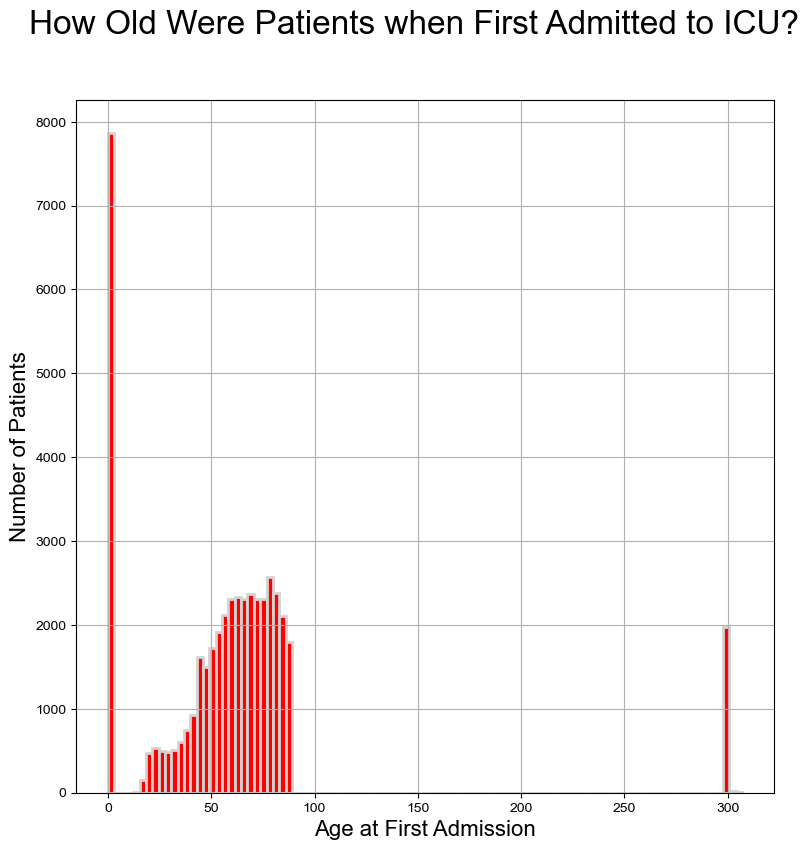

In [396]:
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(eval_df["AGE_AT_FIRST_ADMISSION"], bins=100, color="red", linewidth=2, edgecolor="lightgray")
ax.grid()
ax.set_ylabel("Number of Patients", fontsize=16)
ax.set_xlabel("Age at First Admission", fontsize=16)
fig.suptitle("How Old Were Patients when First Admitted to ICU?", fontsize=24)
plt.show()

In [98]:
eval_df["AGE_AT_FIRST_ADMISSION"] = (eval_df["INTIME"].dt.year-eval_df["DOB"].dt.year).clip(0,90)

In [100]:
eval_df["AGE_AT_FIRST_ADMISSION"].describe()

count    46476.000000
mean        52.908189
std         28.779923
min          0.000000
25%         38.000000
50%         60.000000
75%         76.000000
max         90.000000
Name: AGE_AT_FIRST_ADMISSION, dtype: float64

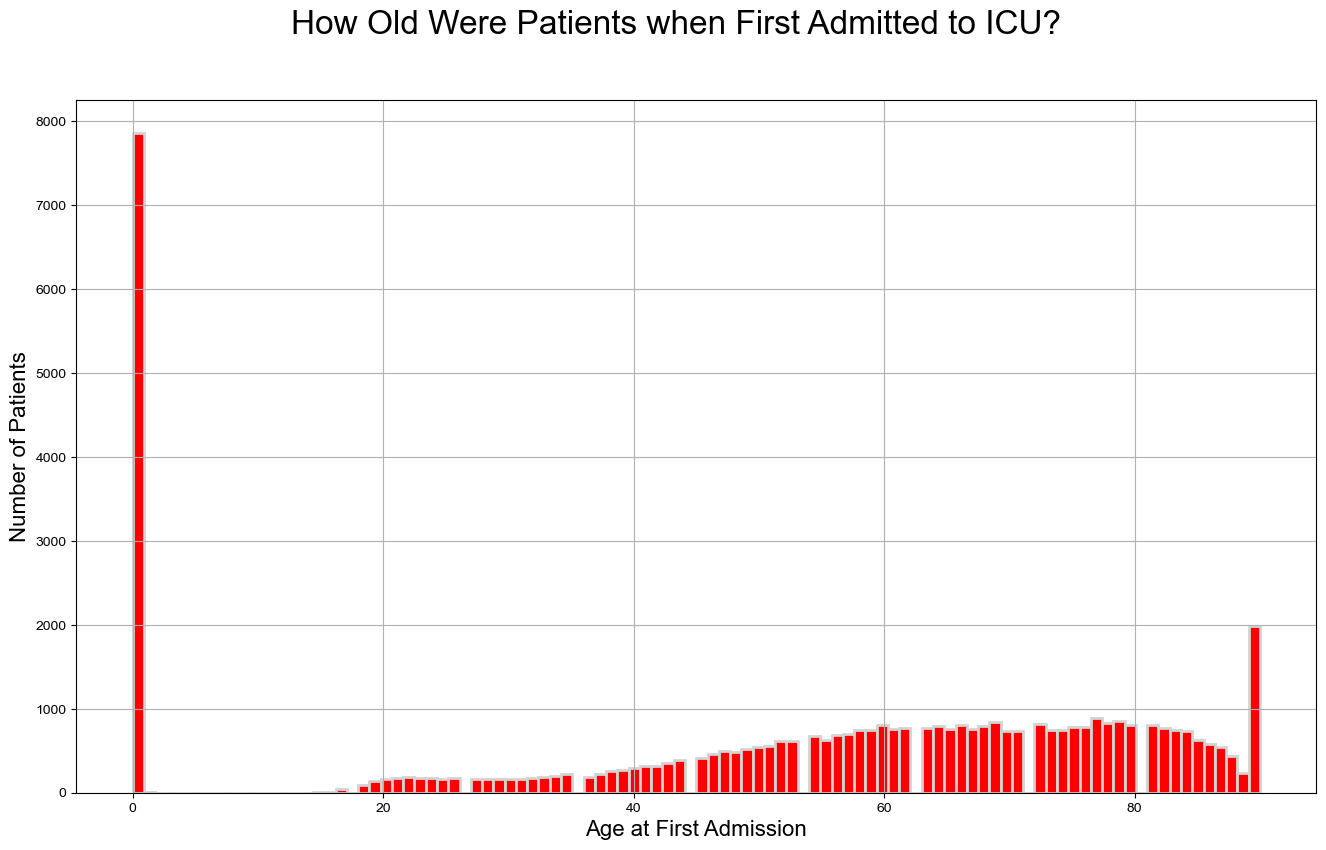

In [99]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(eval_df["AGE_AT_FIRST_ADMISSION"], bins=100, color="red", linewidth=2, edgecolor="lightgray")
ax.grid()
ax.set_ylabel("Number of Patients", fontsize=16)
ax.set_xlabel("Age at First Admission", fontsize=16)
fig.suptitle("How Old Were Patients when First Admitted to ICU?", fontsize=24)
plt.show()

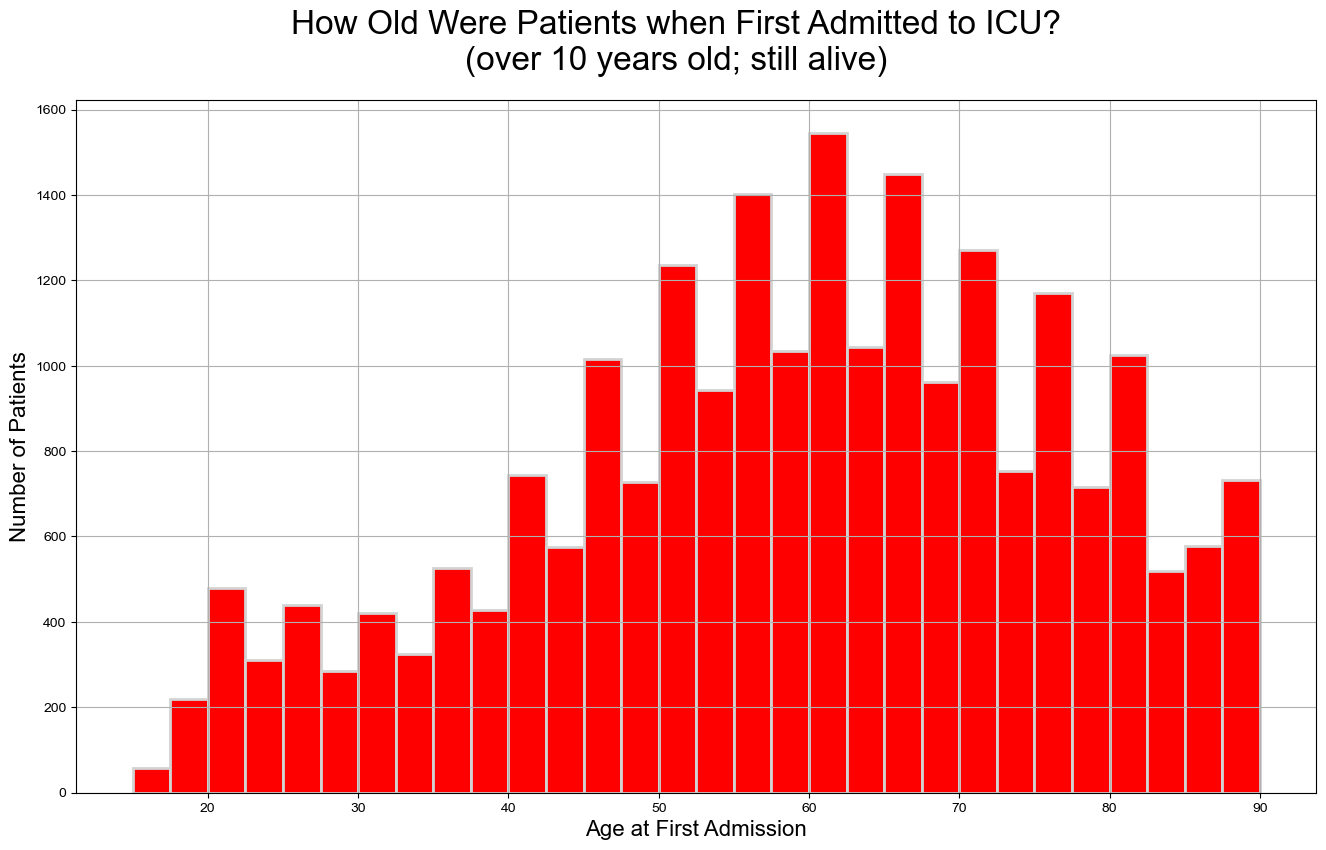

In [106]:
fig, ax = plt.subplots(figsize=(16,9))
loc = eval_df["AGE_AT_FIRST_ADMISSION"].gt(10) & eval_df["DOD"].isna()
ax.hist(eval_df["AGE_AT_FIRST_ADMISSION"].loc[loc], bins=30, color="red", linewidth=2, edgecolor="lightgray")
ax.grid()
ax.set_ylabel("Number of Patients", fontsize=16)
ax.set_xlabel("Age at First Admission", fontsize=16)
fig.suptitle("How Old Were Patients when First Admitted to ICU?\n(over 10 years old; still alive)", fontsize=24)
plt.show()

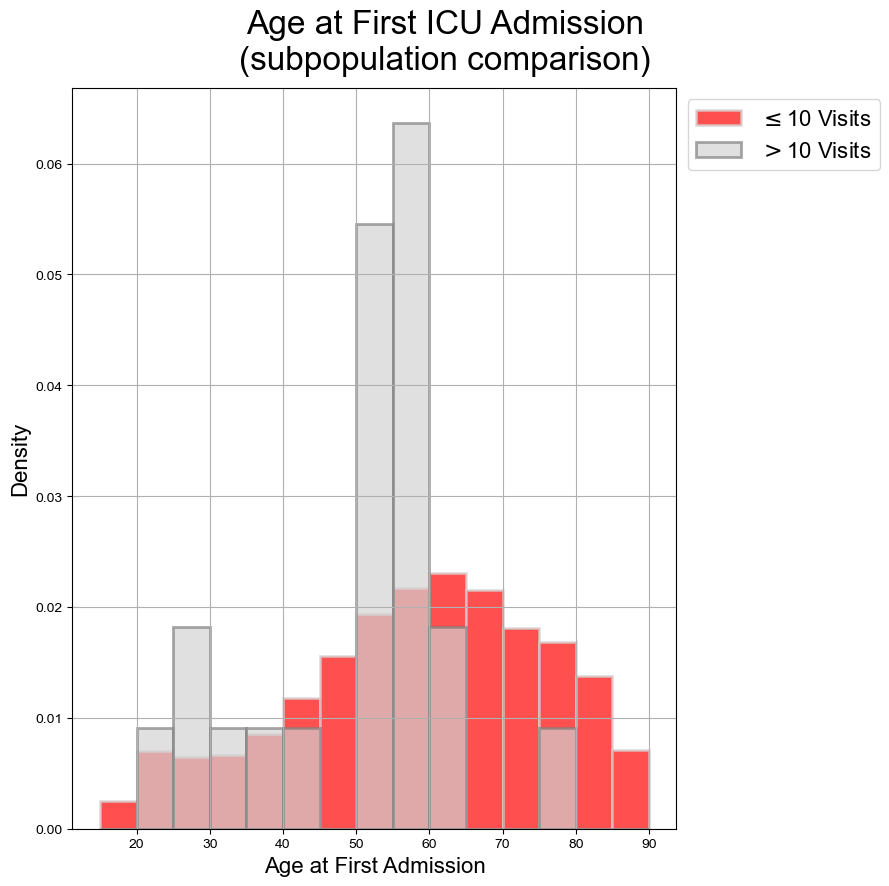

In [397]:
fig, ax = plt.subplots(figsize=(9,9))
loc = eval_df["AGE_AT_FIRST_ADMISSION"].gt(10) & eval_df["DOD"].isna()
bins=np.arange(15,95,5)
ax.hist(eval_df["AGE_AT_FIRST_ADMISSION"].loc[loc & (~eval_df["SUBJECT_ID"].isin(gt_stay_subject_ids))], 
        label="$\\leq$10 Visits", bins=bins, density=True, alpha=.69, color="red", edgecolor="lightgray", linewidth=2)
ax.hist(eval_df["AGE_AT_FIRST_ADMISSION"].loc[loc & (eval_df["SUBJECT_ID"].isin(gt_stay_subject_ids))], 
        label="$>$10 Visits", bins=bins, density=True, alpha=.69, color="lightgray", edgecolor="gray", linewidth=2)
ax.grid()
ax.legend(fontsize=16, bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlabel("Age at First Admission", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
fig.suptitle("Age at First ICU Admission\n(subpopulation comparison)", fontsize=24)
plt.tight_layout()
plt.show()

# Days of Stay by Visit Number

In [189]:
icu_stays_df["VISIT_NUMBER"] = icu_stays_df.groupby("SUBJECT_ID").cumcount()+1

In [198]:
icu_stays_df.shape

(61532, 16)

In [285]:
# get the visit numbers and then bin by days of stay; normalize for each visit number so the heat map as more meaning
eval_df = icu_stays_df[["VISIT_NUMBER", "LOS"]].dropna()
results, xbins, ybins = np.histogram2d(eval_df["VISIT_NUMBER"].clip(1,45), eval_df["LOS"].clip(0,14)
               ,bins=[np.arange(1,50,1), np.arange(0,15,1)])
results = (results / results.sum(axis=1, keepdims=True))
results = np.nan_to_num(results, 0)

C:\Users\ricej\AppData\Local\Temp\ipykernel_36456\3965564950.py:3: RuntimeWarning: invalid value encountered in divide
  results = (results / results.sum(axis=1, keepdims=True))


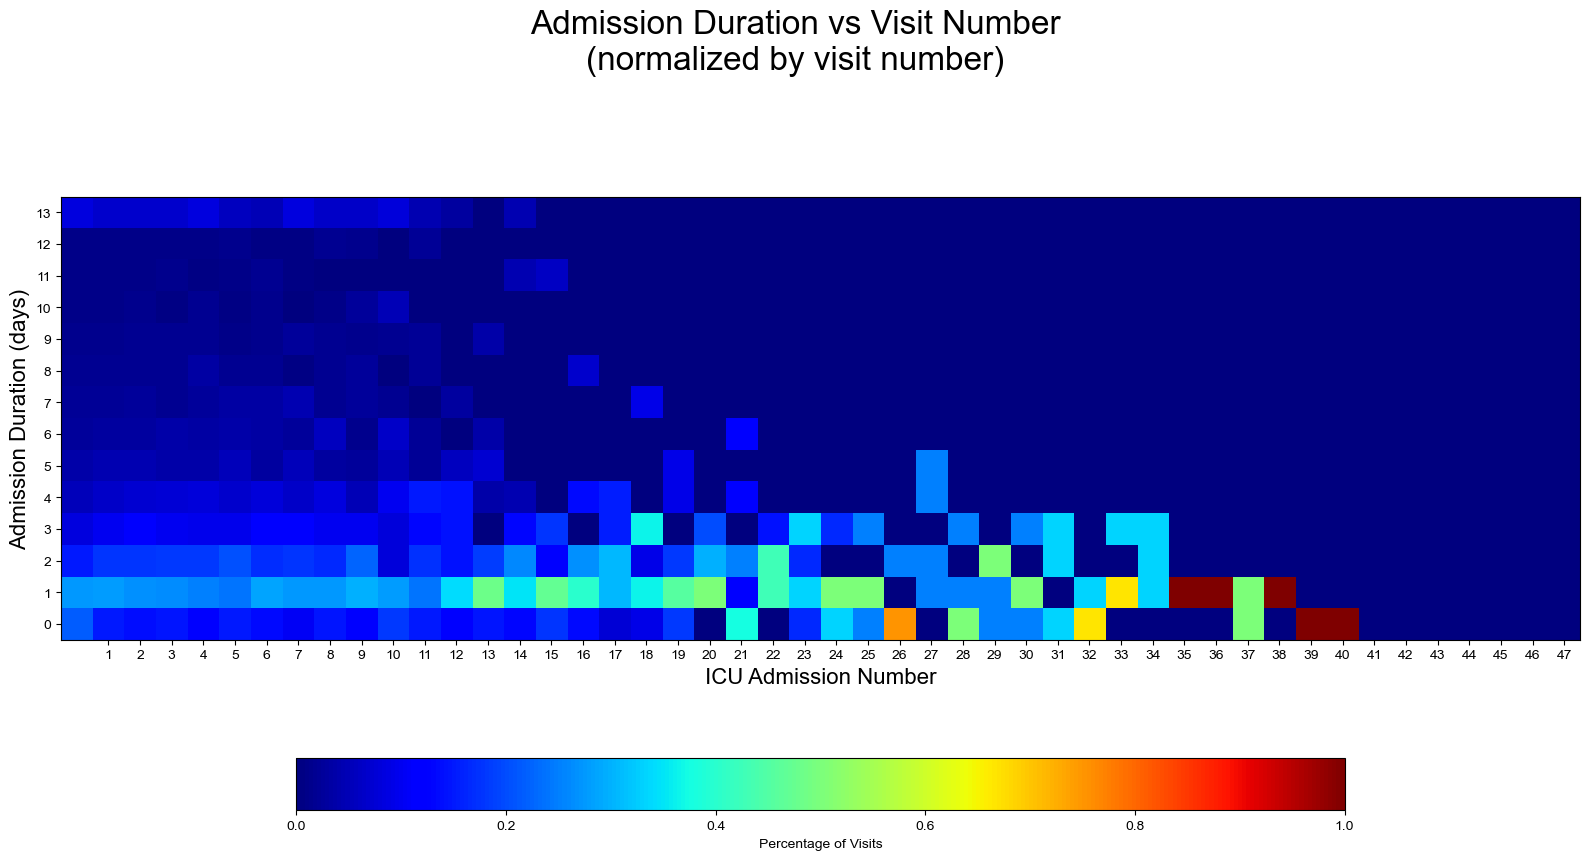

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xticks(xbins)
ax.set_yticks(ybins)
hm = ax.imshow(results.T, cmap="jet")
ax.invert_yaxis()
ax.set_ylabel("Admission Duration (days)", fontsize=16)
ax.set_xlabel("ICU Admission Number", fontsize=16)
fig.colorbar(hm, ax=ax, label="Percentage of Visits", orientation="horizontal", shrink=.69)
fig.suptitle("Admission Duration vs Visit Number\n(normalized by visit number)", fontsize=24)
plt.tight_layout()
plt.show()

# First vs Final ICU in a Stay

In [409]:
icu_stays_df.pivot_table(index="FIRST_CAREUNIT", columns="LAST_CAREUNIT", 
                         values="ROW_ID", aggfunc="count", fill_value=0).T

FIRST_CAREUNIT,CCU,CSRU,MICU,NICU,SICU,TSICU
LAST_CAREUNIT,,,,,,
CCU,6714,270,281,0,74,67
CSRU,479,8759,89,0,40,25
MICU,399,142,20080,0,374,315
NICU,0,0,0,8100,0,0
SICU,92,103,456,0,8300,262
TSICU,42,38,182,0,103,5746


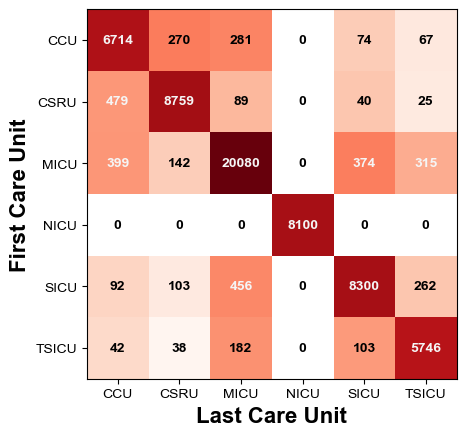

In [410]:
eval_df = icu_stays_df.pivot_table(index="FIRST_CAREUNIT", columns="LAST_CAREUNIT", 
                                   values="ROW_ID", aggfunc="count", fill_value=0)
plt.imshow(eval_df, norm=LogNorm(), cmap="Reds")
plt.xticks(labels=icu_stays_df["LAST_CAREUNIT"].sort_values().unique(), ticks=range(6))
plt.yticks(labels=icu_stays_df["FIRST_CAREUNIT"].sort_values().unique(), ticks=range(6))

for i in range(6):
    for j in range(6):
        val = eval_df.iloc[i].iloc[j]
        plt.text(i, j, val, ha="center", va="center", color="whitesmoke" if i==j or val>300 else "black", fontweight="bold")

plt.ylabel("First Care Unit", fontweight="bold", fontsize=16)
plt.xlabel("Last Care Unit", fontweight="bold", fontsize=16)
plt.show()

# High frequency visitors - what is schedule?

In [154]:
loc = icu_stays_df["SUBJECT_ID"].isin(gt_stay_subject_ids)
icu_stays_df.loc[loc]["SUBJECT_ID"].value_counts()

SUBJECT_ID
13033    41
109      38
11861    35
5060     31
20643    25
         ..
11043    11
18982    11
25708    11
16200    11
98220    11
Name: count, Length: 61, dtype: int64

In [152]:
icu_stays_df["FIRST_TIME_FOR_SUBJECT"] = icu_stays_df.groupby(["SUBJECT_ID"])["INTIME"].transform("min")
icu_stays_df["IN_ELAPSED_DAYS"] = (icu_stays_df["INTIME"]-icu_stays_df["FIRST_TIME_FOR_SUBJECT"])/pd.to_timedelta(1, "day")
icu_stays_df["OUT_ELAPSED_DAYS"] = (icu_stays_df["OUTTIME"]-icu_stays_df["FIRST_TIME_FOR_SUBJECT"])/pd.to_timedelta(1, "day")

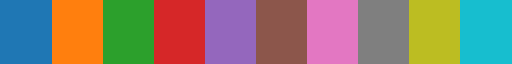

In [380]:
plt.get_cmap("tab10")

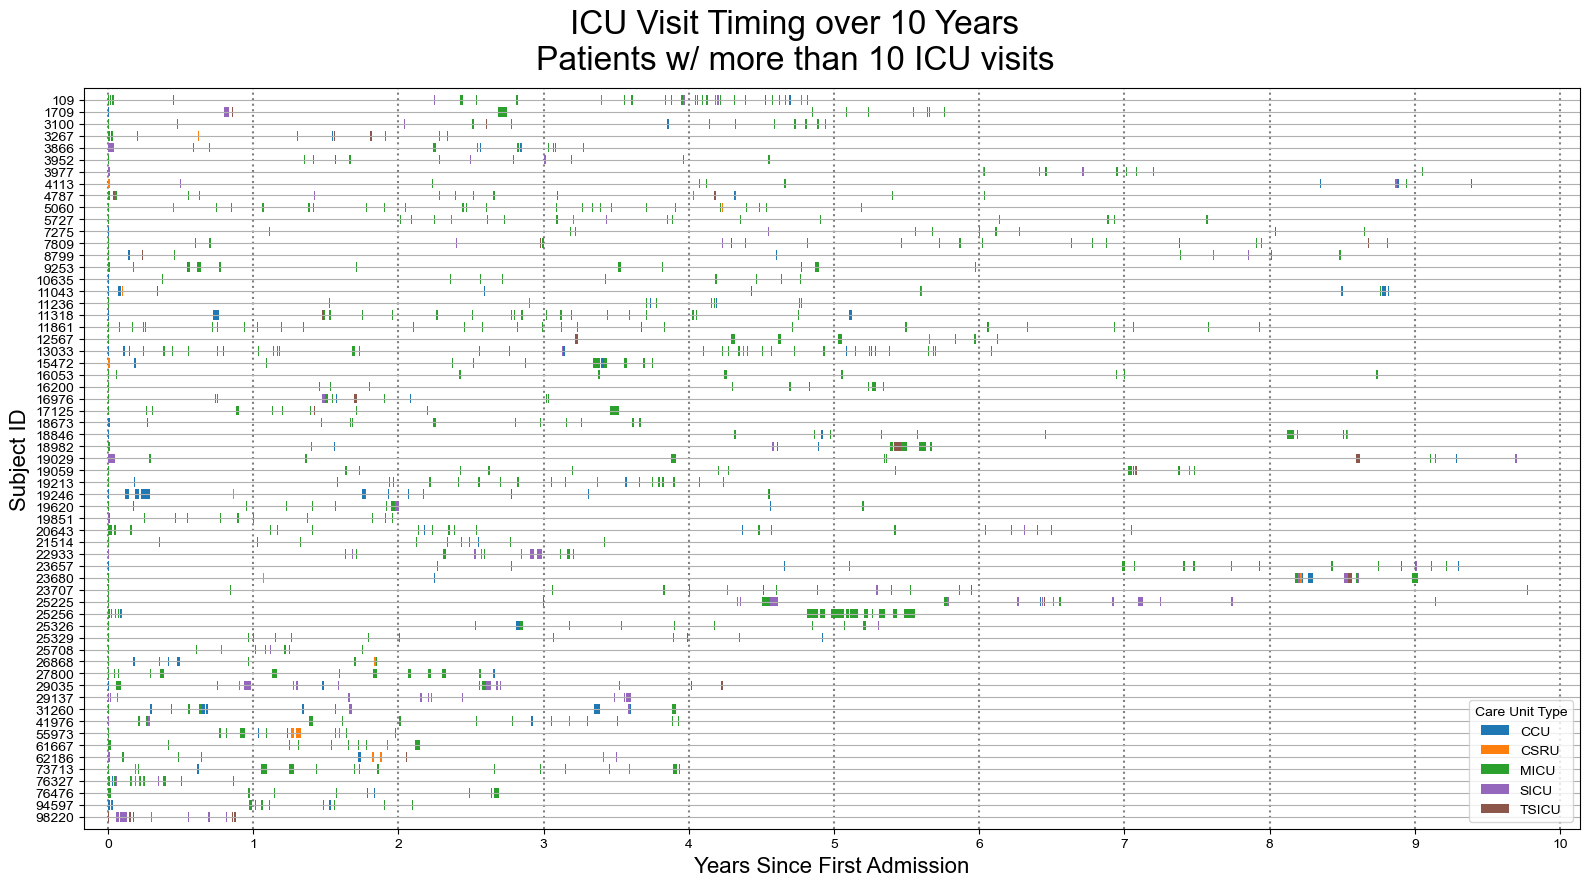

In [ ]:
cmap = plt.get_cmap("tab10")
cmap_dict = {cu: cmap(i) for i, cu in enumerate(icu_stays_df[["FIRST_CAREUNIT", "LAST_CAREUNIT"]].melt()["value"].sort_values().unique())}
lgd_dict = {cu: cu for i, cu in enumerate(icu_stays_df[["FIRST_CAREUNIT", "LAST_CAREUNIT"]].melt()["value"].sort_values().unique())}

fig, ax = plt.subplots(figsize=(16,9))

#icu_stays_df.sort_values(by=["FIRST_CAREUNIT", "LAST_CAREUNIT"], inplace=True)

proc_list = list(reversed(gt_stay_subject_ids))

for i, subject in enumerate(proc_list):#enumerate():
    loc = icu_stays_df["SUBJECT_ID"].eq(subject)
    for stay in icu_stays_df.loc[loc].itertuples():
        halfway = np.max([(stay.OUT_ELAPSED_DAYS - stay.IN_ELAPSED_DAYS)/2, 1])
        ax.barh(i, halfway, left=stay.IN_ELAPSED_DAYS, color=cmap_dict[stay.FIRST_CAREUNIT], label=lgd_dict[stay.FIRST_CAREUNIT])
        lgd_dict[stay.FIRST_CAREUNIT] = ""
        ax.barh(i, halfway, left=stay.IN_ELAPSED_DAYS+halfway, color=cmap_dict[stay.LAST_CAREUNIT], label=lgd_dict[stay.LAST_CAREUNIT])
        lgd_dict[stay.LAST_CAREUNIT] = ""
    
ax.set_yticks(ticks=range(i+1), labels=proc_list)
ax.set_xticks(ticks=np.arange(0,3650+365, 365), labels=range(11))

handles, labels = ax.get_legend_handles_labels()

# add vertical lines by year
ax.grid(axis="y")
for i in range(11):
    ax.vlines(i*365, -1, len(proc_list), colors="gray", zorder=-99, linestyles="dotted")

ax.set_xlim(-60,3700)
ax.set_ylim(-1, len(proc_list))

# sort the legend
sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0])  # Sort alphabetically
sorted_labels, sorted_handles = zip(*sorted_pairs)

ax.legend(sorted_handles, sorted_labels, title="Care Unit Type")

ax.set_ylabel("Subject ID", fontsize=16)
ax.set_xlabel("Years Since First Admission", fontsize=16)
fig.suptitle("ICU Visit Timing over 10 Years\nPatients w/ more than 10 ICU visits", fontsize=24)
plt.tight_layout()
plt.show()

# Network Diagram; moves in a stay

In [309]:
transfers_df.sort_values(by=["HADM_ID", "INTIME"], inplace=True)

In [310]:
transfers_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
193492,203038,58526,100001,275225.0,metavision,admit,NaN,MICU,NaN,52.0,2117-09-11 11:47:35,2117-09-11 12:51:56,1.07
193493,203039,58526,100001,275225.0,metavision,transfer,MICU,MICU,52.0,52.0,2117-09-11 12:51:56,2117-09-15 17:57:14,101.09
193494,203040,58526,100001,NaN,metavision,transfer,MICU,NaN,52.0,29.0,2117-09-15 17:57:14,2117-09-17 16:46:20,46.82
193495,203041,58526,100001,NaN,metavision,discharge,NaN,NaN,29.0,NaN,2117-09-17 16:46:20,NaT,NaN
203051,197283,54610,100003,209281.0,metavision,admit,NaN,MICU,NaN,50.0,2150-04-17 15:35:42,2150-04-17 15:51:17,0.26


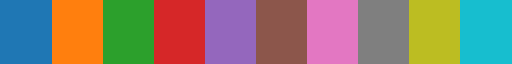

In [383]:
cmap

In [384]:
cmap_dict["ADMISSION"] = cmap(8)
cmap_dict["DISCHARGE"] = cmap(9)

In [401]:
transfers = {"ADMISSION": {}, "DISCHARGE": {}}

i = 0
for xfer in transfers_df.loc[~transfers_df["SUBJECT_ID"].isin(gt_stay_subject_ids)].itertuples():
    i+=1
    if pd.isna(xfer.EVENTTYPE):
        continue
    
    prev_ward = "NON-ICU\nWARD"#str(int(xfer.PREV_WARDID)) if not pd.isna(xfer.PREV_WARDID) else ""
    curr_ward = "NON-ICU\nWARD"#str(int(xfer.CURR_WARDID)) if not pd.isna(xfer.CURR_WARDID) else ""
    origin = ""
    destination = ""
    if xfer.EVENTTYPE=="admit":
        origin = "ADMISSION"
        #destination = str(int(xfer.CURR_WARDID)) if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
        destination = curr_ward if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
    elif xfer.EVENTTYPE=="discharge":
        origin = prev_ward if pd.isna(xfer.PREV_CAREUNIT) else xfer.PREV_CAREUNIT
        destination = "DISCHARGE"
    else:
        origin = prev_ward if pd.isna(xfer.PREV_CAREUNIT) else xfer.PREV_CAREUNIT 
        destination = curr_ward if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
    
    if origin not in transfers.keys():
        transfers[origin] = {}
    
    if destination not in transfers[origin].keys():
        transfers[origin][destination] = 0
    
    transfers[origin][destination] += 1

99342


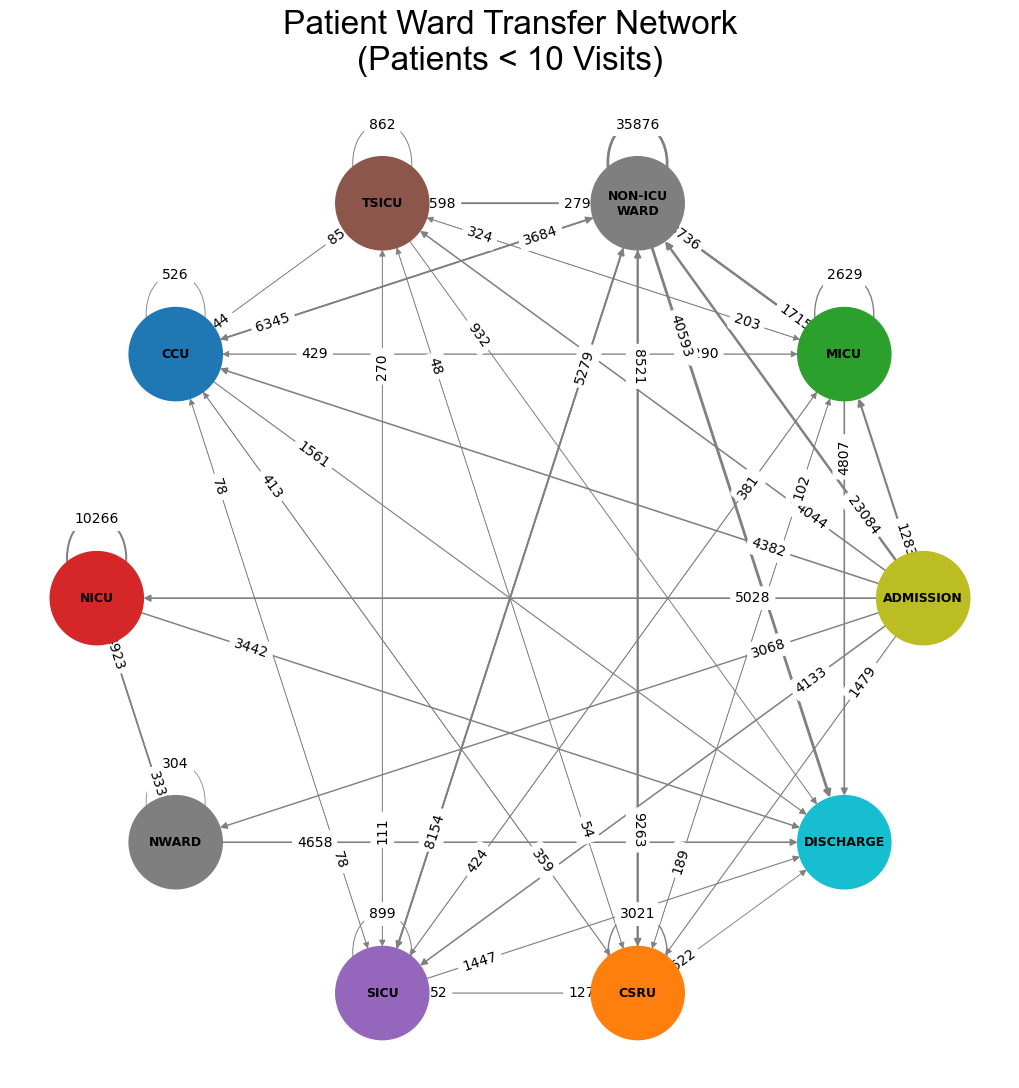

In [402]:
seed = np.random.randint(0,999999)
print(seed)
G = nx.DiGraph()

for from_ward, destinations in transfers.items():
    for to_ward, weight in destinations.items():
        G.add_edge(from_ward, to_ward, weight=weight)

plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)#, seed=seed)#787718 

edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

min_width = 3
max_width = 100  
edge_widths = [np.log10((w / max(edge_weights)) * max_width + min_width) for w in edge_weights]

node_colors = [cmap_dict.get(node, cmap(7)) for node in G.nodes]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=4500, font_size=9, 
        width=edge_widths, font_weight="bold")


#edge_labels = {(u, v): "" for u, v, d in G.edges(data=True)}
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=.2)

plt.title("Patient Ward Transfer Network\n(Patients < 10 Visits)", fontsize=24)
plt.show()

In [403]:
transfers = {"ADMISSION": {}, "DISCHARGE": {}}

i = 0
for xfer in transfers_df.loc[transfers_df["SUBJECT_ID"].isin(gt_stay_subject_ids)].itertuples():
    i+=1
    if pd.isna(xfer.EVENTTYPE):
        continue
    
    prev_ward = "NON-ICU\nWARD"#str(int(xfer.PREV_WARDID)) if not pd.isna(xfer.PREV_WARDID) else ""
    curr_ward = "NON-ICU\nWARD"#str(int(xfer.CURR_WARDID)) if not pd.isna(xfer.CURR_WARDID) else ""
    origin = ""
    destination = ""
    if xfer.EVENTTYPE=="admit":
        origin = "ADMISSION"
        #destination = str(int(xfer.CURR_WARDID)) if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
        destination = curr_ward if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
    elif xfer.EVENTTYPE=="discharge":
        origin = prev_ward if pd.isna(xfer.PREV_CAREUNIT) else xfer.PREV_CAREUNIT
        destination = "DISCHARGE"
    else:
        origin = prev_ward if pd.isna(xfer.PREV_CAREUNIT) else xfer.PREV_CAREUNIT 
        destination = curr_ward if pd.isna(xfer.CURR_CAREUNIT) else xfer.CURR_CAREUNIT
    
    if origin not in transfers.keys():
        transfers[origin] = {}
    
    if destination not in transfers[origin].keys():
        transfers[origin][destination] = 0
    
    transfers[origin][destination] += 1

600755


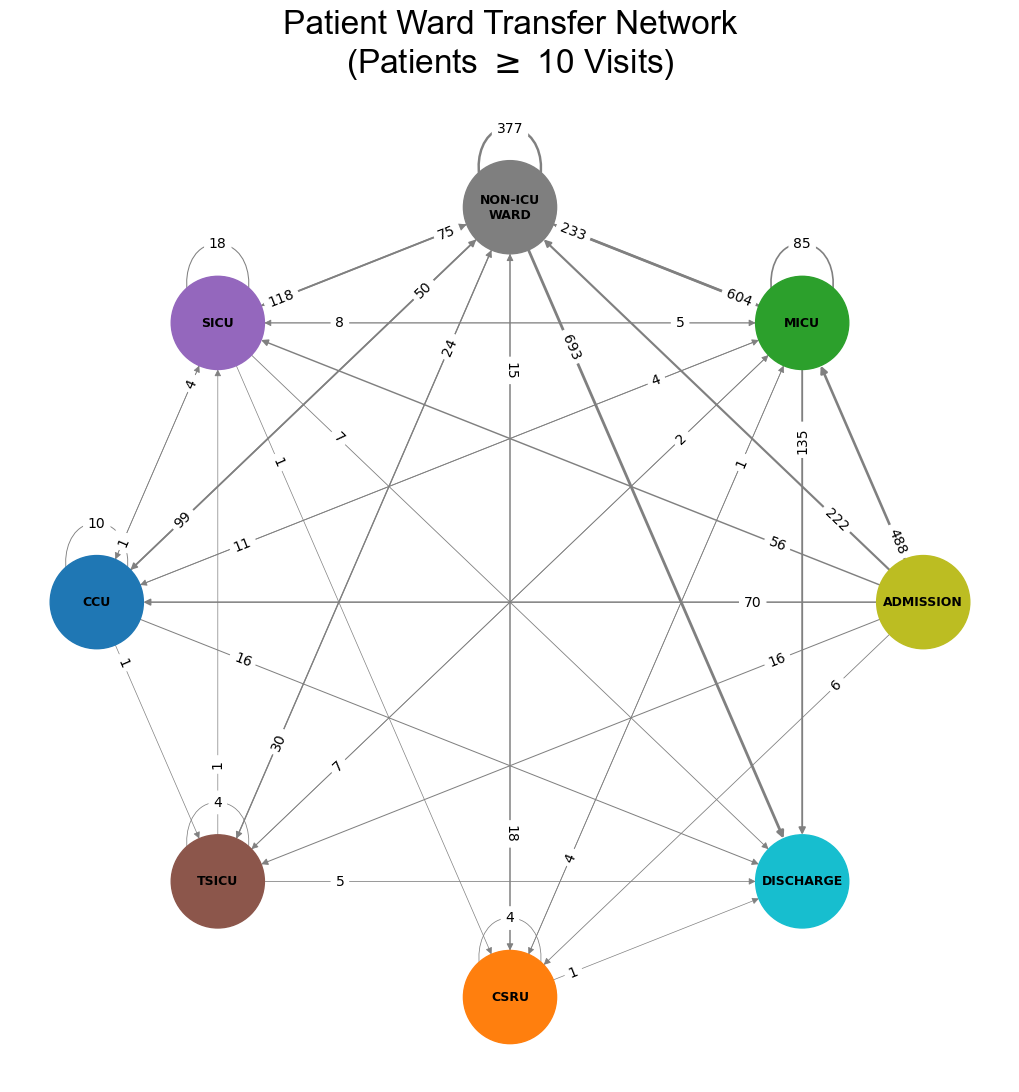

In [406]:
# Create a directed graph
seed = np.random.randint(0,999999)
print(seed)
G = nx.DiGraph()

for from_ward, destinations in transfers.items():
    for to_ward, weight in destinations.items():
        G.add_edge(from_ward, to_ward, weight=weight)

plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G)#, seed=seed)#787718 

edge_weights = [d['weight'] for _, _, d in G.edges(data=True)]

min_width = 3
max_width = 100  
edge_widths = [np.log10((w / max(edge_weights)) * max_width + min_width) for w in edge_weights]

node_colors = [cmap_dict.get(node, cmap(7)) for node in G.nodes]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=4500, font_size=9, 
        width=edge_widths, font_weight="bold")


#edge_labels = {(u, v): "" for u, v, d in G.edges(data=True)}
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=.2)

plt.title("Patient Ward Transfer Network\n(Patients $\\geq$ 10 Visits)", fontsize=24)
plt.show()